In [1]:
%matplotlib inline

#Load required modules
import sys, os, argparse
import matplotlib.pyplot as plt
import matplotlib as mpl
from statsmodels.graphics.boxplots import violinplot
import numpy as np
import seaborn as sns
import pandas as pd

### Set up seaborn appearence
mpl.rc('text', usetex = True)
sns.set_context("notebook", font_scale=1.5)
colors= [ "#d1fffc", "#00ada4", "#edc9ff", "#ae00ff", "#ffc18c", "#d66300"]
sns.set_palette(colors)
pc_map = {'mS':0, 'pS': 1, 'mM': 2, 'pM': 3, 'mR': 4, 'pR': 5}

In [2]:
# import data
directory = '../simulation_results_20170921/'
files_new_m5=[directory + f for f in ['results_MACHINA_m5.txt','results_m5_NJ.txt','results_m5_noSub.txt','results_m5_sub.txt']]
files_new_m8=[directory + f for f in ['results_MACHINA_m8.txt','results_m8_NJ.txt','results_m8_noSub.txt','results_m8_sub.txt']]

res_m5 = pd.concat([pd.read_csv(filename) for filename in files_new_m5]).reindex()
res_m8 = pd.concat([pd.read_csv(filename) for filename in files_new_m8]).reindex()
res_m5 = res_m5[(res_m5['enforced']=='R') | (res_m5['enforced'].isnull())]
res_m8 = res_m8[(res_m8['enforced']=='R') | (res_m8['enforced'].isnull())]

res_m5_MACHINA = res_m5[res_m5['method'] == 'MACHINA'].replace({'inferred': {'pPS': 'pS', 'mPS' : 'mS'}})
res_m8_MACHINA = res_m8[res_m8['method'] == 'MACHINA'].replace({'inferred': {'pPS': 'pS', 'mPS' : 'mS'}})

In [3]:
# Create proportion bar plot

r = []
def normalize(x):
    return float(x['seed'])/sum(r.loc[x.name[0]]['seed'])

def plot_proportions(results, filename):
    global r
    fig = plt.figure(figsize=(7,12))
    gs = mpl.gridspec.GridSpec(5, 1, height_ratios=[1,7,7,7,7])
    
    norm = mpl.colors.Normalize(vmin=min(results['RF']), vmax=max(results['RF']))

    cb1 = mpl.colorbar.ColorbarBase(plt.subplot(gs[0]), cmap=plt.get_cmap('YlGnBu'),
                                    norm=norm,
                                    orientation='horizontal',
                                    boundaries=range(min(results['RF']),max(results['RF'] + 1)))
    
    cb1.set_ticks(np.arange(0, max(results['RF'])+1, 2.0))
    
    plt.subplot(gs[0]).set_title("Robinson-Foulds distance")
    
    for i,v in enumerate(['mS', 'pS', 'pM', 'pR']):
        r = results[results['pattern'] == v].groupby(['method', 'RF']).count()
        r['norm'] = r.apply( normalize, axis = 1)
        #r.reset_index().sort_values(['method', 'RF'])
        ax = plt.subplot(gs[i+1])
        
        r['norm'].unstack(level=-1).plot.barh(stacked=True, colormap = 'YlGnBu', ax=ax, legend=False)

        ax.set_xlim(0,1.01)
        ax.set_xticks(np.arange(0, 1.05, .1))
        ax.set_ylim(reversed(ax.get_ylim())) # Reverse the order of the methods to match the ohe
        plt.ylabel(v, rotation=0, size=25, labelpad=30)

        if i == 3:
            ax.set_xlabel("proportion")
            
    plt.tight_layout()
    plt.savefig(filename)
    # plt.close()

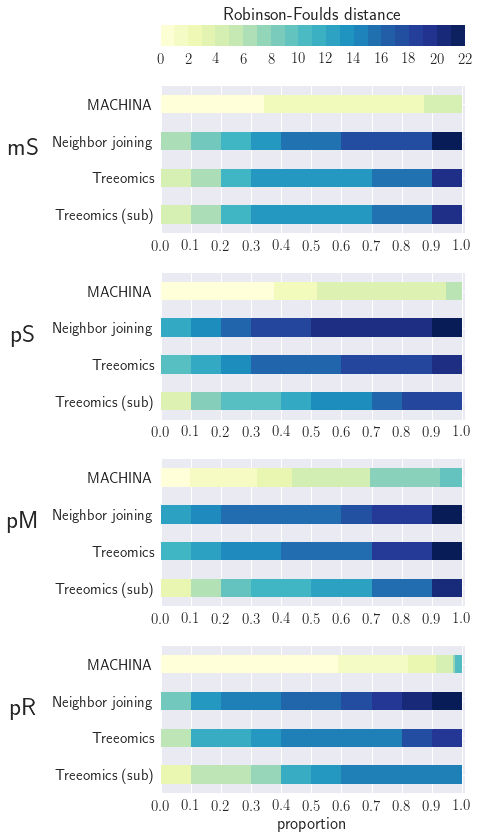

In [4]:
plot_proportions(res_m5, "proportions_m5.pdf")

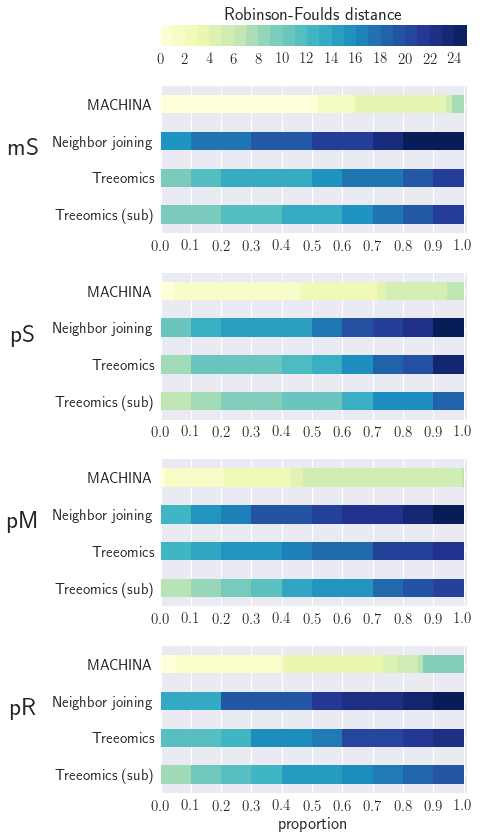

In [5]:
plot_proportions(res_m8, "proportions_m8.pdf")

In [6]:
def distance_boxplots(results, filename):
    for i,v in enumerate(['mS', 'pS', 'pM', 'pR']):
        r = results[results['pattern'] == v]

        plt.subplot(4,1,i+1)

        clr = sns.color_palette()[pc_map[v]]
        sns.boxplot(data = r,  x = 'RF', y = 'method', showfliers=False, palette=[clr, clr, clr, clr])
        sns.stripplot(data = r, jitter=0.15, x = 'RF', y = 'method', color=".3", alpha=0.6)
        plt.gcf().set_size_inches(7, 12)
        plt.ylabel(v, rotation=0, size=25, labelpad=30)
        plt.xlim((-1,max(results['RF'])+1))
        plt.xticks(np.arange(0, max(results['RF'])+1, 2.0))
        if i == 3:
            plt.xlabel("Robinson-Foulds distance")
        else: 
            plt.xlabel("")

    plt.tight_layout()
    plt.savefig(filename)
    plt.close()
    
    
def distance_boxplots_square(results, filename):
    for i,v in enumerate(['mS', 'pS', 'pM', 'pR']):
        r = results[results['pattern'] == v]

        plt.subplot(2,2,i+1)

        clr = sns.color_palette()[pc_map[v]]
        sns.boxplot(data = r,  x = 'RF', y = 'method', showfliers=False, palette=[clr, clr, clr, clr])
        sns.stripplot(data = r, jitter=0.15, x = 'RF', y = 'method', color=".3", alpha=0.6)
        plt.gcf().set_size_inches(10, 7)
        plt.ylabel("")#v, rotation=0, size=25, labelpad=30)
        #plt.title(v)
        plt.xlim((-1,max(results['RF'])+1))
        plt.xticks(np.arange(0, max(results['RF'])+1, 2.0))
        if i in [1,3]:
            plt.yticks([],[])
        if i in [2,3]:
            plt.xlabel("distance")
        else: 
            plt.xlabel("")

    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

In [7]:
distance_boxplots(res_m5,"m5_RF_results.pdf")
distance_boxplots(res_m8,"m8_RF_results.pdf")

In [8]:
distance_boxplots_square(res_m5,"m5_RF_results_square.pdf")
distance_boxplots_square(res_m8,"m8_RF_results_square.pdf")

In [9]:
def plot_clone_scores(res, filename):
    r = res.groupby(['pattern','seed'])['FscoreT'].mean().to_frame("FscoreT").reset_index(level=0)
    order = ['mS', 'pS', 'pM', 'pR']
    colors = [sns.color_palette()[pc_map[i]] for i in order] 
    sns.boxplot(data = r,  y = 'FscoreT', x = 'pattern', order = order, showfliers=False, palette = colors)
    ax = sns.stripplot(data = r, jitter=0.15, y = 'FscoreT', x = 'pattern', order = ['mS', 'pS', 'pM', 'pR'], color=".3", alpha=0.6)
    plt.gcf().set_size_inches(4.5, 3)
    plt.ylim(0, 1.07)
    ax.set_xlabel("")
    ax.set_ylabel("migrating clones $F_1$ score")
    plt.savefig(filename, bbox_inches="tight")
    #plt.close()

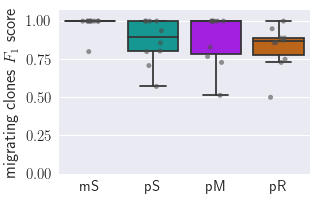

In [10]:
plot_clone_scores(res_m5_MACHINA, "m5_migration_clones.pdf")

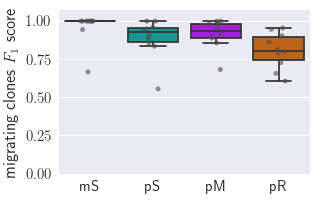

In [11]:
plot_clone_scores(res_m8_MACHINA, "m8_migration_clones.pdf")

In [12]:
def plot_graph_scores(res, filename):
    r = res.groupby(['pattern','seed'])['FscoreG'].mean().to_frame("FscoreG").reset_index(level=0)
    order = ['mS', 'pS', 'pM', 'pR']
    colors = [sns.color_palette()[pc_map[i]] for i in order] 
    sns.boxplot(data = r,  y = 'FscoreG', x = 'pattern', order = ['mS', 'pS', 'pM', 'pR'], showfliers=False, palette = colors)
    ax = sns.stripplot(data = r, jitter=0.15, y = 'FscoreG', x = 'pattern', order = ['mS', 'pS', 'pM', 'pR'], color=".3", alpha=0.6)
    plt.gcf().set_size_inches(4.5, 3)
    plt.ylim(0, 1.07)
    ax.set_xlabel("")
    ax.set_ylabel("migration graph $F_1$ score")
    plt.savefig(filename, bbox_inches="tight")
    #plt.close()

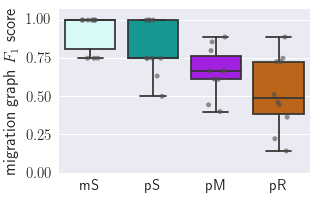

In [13]:
plot_graph_scores(res_m5_MACHINA, "m5_migration_graph.pdf")

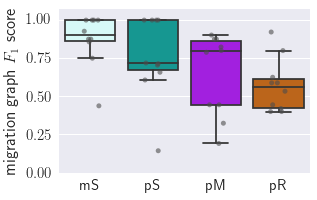

In [14]:
plot_graph_scores(res_m8_MACHINA, "m8_migration_graph.pdf")

In [15]:
df_5_cpy = res_m5_MACHINA.drop_duplicates(subset=['pattern', 'seed']).groupby(['pattern','inferred'])['pattern'].count().unstack(level=-1).fillna(0)
df_5_cpy

inferred,mM,mS,pR,pS
pattern,,,,
mS,0.0,10.0,0.0,0.0
pM,3.0,1.0,0.0,6.0
pR,1.0,2.0,1.0,6.0
pS,0.0,2.0,0.0,8.0


In [16]:
res_m8_MACHINA.groupby(['pattern','seed'])['FscoreG'].mean().to_frame("FscoreG").reset_index(level=0)

,pattern,FscoreG
seed,,
0,mS,0.875000
2,mS,0.437500
3,mS,0.875000
4,mS,0.857143
5,mS,1.000000
7,mS,1.000000
8,mS,1.000000
9,mS,0.750000
10,mS,1.000000


In [17]:
res_m5_MACHINA[(res_m5_MACHINA.pattern == 'pM') & (res_m5_MACHINA.mut_tree == 0.0)]

,FscoreG,FscoreT,RF,enforced,gamma,inferred,method,mu,mut_tree,pattern,precisionG,precisionT,recallG,recallT,seed,sigma
7,0.444444,0.75,3,R,4.0,pS,MACHINA,5.0,0.0,pM,0.500000,0.75,0.400000,0.75,209,3.0
63,0.800000,1.00,1,R,5.0,mM,MACHINA,5.0,0.0,pM,0.800000,1.00,0.800000,1.00,512,3.0
85,0.727273,1.00,5,R,5.0,mS,MACHINA,5.0,0.0,pM,0.800000,1.00,0.666667,1.00,545,3.0
90,0.666667,1.00,1,R,4.0,pS,MACHINA,6.0,0.0,pM,0.750000,1.00,0.600000,1.00,565,2.0
99,0.666667,0.80,0,R,4.0,pS,MACHINA,6.0,0.0,pM,0.750000,0.80,0.600000,0.80,76,1.0
102,0.400000,1.00,2,R,5.0,mM,MACHINA,5.0,0.0,pM,0.400000,1.00,0.400000,1.00,865,3.0
110,0.666667,1.00,1,R,6.0,mM,MACHINA,6.0,0.0,pM,0.666667,1.00,0.666667,1.00,907,3.0


In [37]:

def bar_stack(res, filename):
    print res.head()
    patterns = ['mS', 'pS', 'mM', 'pM', 'mR', 'pR']
    res_MACHINA = res[res['method'] == 'MACHINA'].replace({'inferred': {'pPS': 'pS', 'mPS' : 'mS'}})
    df = res_MACHINA.drop_duplicates(subset=['pattern', 'seed']).groupby(['pattern','inferred'])['pattern'].count().unstack(level=-1).fillna(0).reindex(['mS', 'pS', 'pM', 'pR'])
    for v in patterns:
        if v not in df.columns:
            df[v]=0
    df = df[patterns].reindex(['mS', 'pS', 'pM', 'pR']) 
    df = df.reindex(['mS', 'pS', 'pM', 'pR'])
    ax = df.div(df.sum(axis=1), axis=0).plot(kind='bar', stacked=True, legend=False, edgecolor='k')
    plt.ylim(0,1)
    ax.legend(patterns, ncol=6, loc="upper center", bbox_to_anchor=(0.5, 1.2), title="inferred pattern")
    ax.set_xlabel('simulated pattern')
    ax.set_ylabel('proportion')
    plt.savefig(filename, bbox_inches="tight")

    

    FscoreG  FscoreT  RF enforced  gamma inferred   method    mu  mut_tree  \
0  0.190476      1.0   4        R   10.0       pM  MACHINA  12.0     103.0   
1  0.190476      1.0   4        R   10.0       pM  MACHINA  12.0     166.0   
2  0.190476      1.0   4        R   10.0       pM  MACHINA  12.0     115.0   
3  0.190476      1.0   4        R   10.0       pM  MACHINA  12.0     101.0   
4  0.190476      1.0   4        R   10.0       pM  MACHINA  12.0      82.0   

  pattern  precisionG  precisionT   recallG  recallT  seed  sigma  
0      pM         0.2         1.0  0.181818      1.0   172    3.0  
1      pM         0.2         1.0  0.181818      1.0   172    3.0  
2      pM         0.2         1.0  0.181818      1.0   172    3.0  
3      pM         0.2         1.0  0.181818      1.0   172    3.0  
4      pM         0.2         1.0  0.181818      1.0   172    3.0  


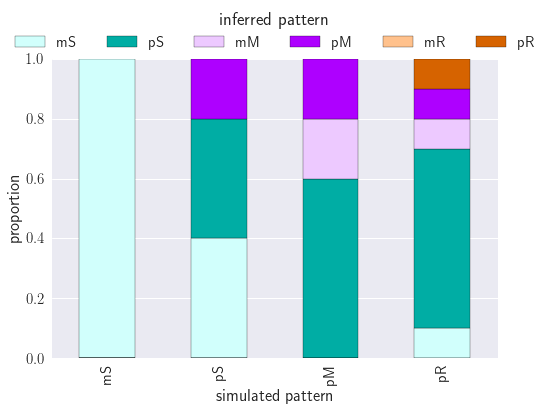

In [38]:
bar_stack(res_m8, "m8_results.pdf")

    FscoreG   FscoreT  RF enforced  gamma inferred   method   mu  mut_tree  \
0  0.444444  0.666667   3        R    4.0       pS  MACHINA  5.0       6.0   
1  0.444444  0.666667   3        R    4.0       pS  MACHINA  5.0       3.0   
2  0.444444  0.750000   3        R    4.0       pS  MACHINA  5.0       2.0   
3  0.444444  0.750000   3        R    4.0       pS  MACHINA  5.0       5.0   
4  0.444444  0.750000   3        R    4.0       pS  MACHINA  5.0       4.0   

  pattern  precisionG  precisionT  recallG  recallT  seed  sigma  
0      pM         0.5        0.60      0.4     0.75   209    3.0  
1      pM         0.5        0.60      0.4     0.75   209    3.0  
2      pM         0.5        0.75      0.4     0.75   209    3.0  
3      pM         0.5        0.75      0.4     0.75   209    3.0  
4      pM         0.5        0.75      0.4     0.75   209    3.0  


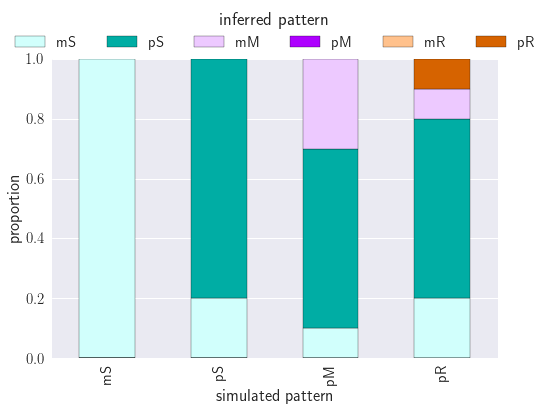

In [39]:
bar_stack(res_m5, "m5_results.pdf")